# SOLAR ORBITER - 2024 - March

This notebook documents the off-web workflow to use 3DCORE for analysis of a realtime Solar Orbiter Event March 2024

(23-03-2024) which gave in-situ signatures on [BepiColombo](https://helioforecast.space/icmecat/ICME_BEPI_MOESTL_20240324_01), [SolO](https://helioforecast.space/icmecat/ICME_SOLO_MOESTL_20240323_01) and [STEREO-A](https://helioforecast.space/icmecat/ICME_STEREO_A_MOESTL_20240324_01). It is reported in the DONKI database [here](https://kauai.ccmc.gsfc.nasa.gov/DONKI/view/CME/29715/5).

number 10 (22-09-2023) in the line-up database giving in-situ signatures on [PSP](https://helioforecast.space/icmecat/ICME_PSP_MOESTL_20230922_01), [Wind](https://helioforecast.space/icmecat/ICME_Wind_MOESTL_20230924_01) and [STEREO-A](https://helioforecast.space/icmecat/ICME_STEREO_A_MOESTL_20230924_01) and reported in the DONKI database [here](https://kauai.ccmc.gsfc.nasa.gov/DONKI/view/CME/27043/2).

In [1]:
from pathlib import Path
import datetime
import pandas as pd

import urllib

import pickle

# suppress warnings
import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append(str(Path.cwd().parent)) 

from src.data.data_cache import get_data_cache
from src.methods.utils import get_modelkwargs_ranges
from src.methods.fitting import standard_fit, load_fit

cache_path = Path.cwd().parent / "cache"

Kernels path loaded: /Volumes/SSDPortable/data/kernels
File names loaded
Data path loaded: /Volumes/SSDPortable/data
Data path loaded: /Volumes/SSDPortable/data


In [2]:
start_date = datetime.datetime(2024,3,23).strftime('%Y-%m-%d')
end_date = datetime.datetime(2024,3,24).strftime('%Y-%m-%d')

url_donki='https://kauai.ccmc.gsfc.nasa.gov/DONKI/WS/get/CMEAnalysis?startDate='+start_date+'&endDate='+end_date+'&mostAccurateOnly=true'
try: urllib.request.urlretrieve(url_donki,cache_path / Path('DONKI.json'))
except urllib.error.URLError as e:
    print('DONKI not loaded')

donkicat = pd.read_json(cache_path / 'DONKI.json')
print(f'# CMEs between {start_date} and {end_date}: ', len(donkicat))

filtered_donki = donkicat[donkicat['associatedCMEID'].str.contains('2024-03-23T01:25:00-CME-001')] # we extract the event with the correct ID
print('# CMEs filtered: ', len(filtered_donki))

# choose correct one!

catalogevent = filtered_donki.iloc[0]

for col in donkicat.columns:
    print(str(col) +': '+ str(catalogevent[col]))

dateFormat = "%Y-%m-%dT%H:%MZ"
cataloglaunchtime = datetime.datetime.strptime(catalogevent['time21_5'], dateFormat)

# CMEs between 2024-03-23 and 2024-03-24:  7
# CMEs filtered:  1
time21_5: 2024-03-23T03:19Z
latitude: 22
longitude: 2
halfAngle: 41
speed: 1613
type: O
isMostAccurate: True
associatedCMEID: 2024-03-23T01:25:00-CME-001
associatedCMEstartTime: 2024-03-23T01:25Z
note: Approximate measurement which follows the brighter bulk portion of this complex-shape event. Measured parameters are based on the source location and the best fit in SOHO LASCO C3 imagery, however the center of the elongated source eruption is not certain. There is a data gap in STEREO A COR2 imagery during this event so there was no stereoscopic viewpoint available to confirm the measured parameters. The half width of this CME is also not certain.
associatedCMELink: https://kauai.ccmc.gsfc.nasa.gov/DONKI/view/CME/29715/-1
catalog: M2M_CATALOG
featureCode: LE
dataLevel: 0
measurementTechnique: SWPC_CAT
imageType: running difference
tilt: nan
minorHalfWidth: nan
speedMeasuredAtHeight: 27.6
submissionTime: 2024-03-23T19:02Z
v

In [3]:
idd = 'ICME_SOLO_MOESTL_20240323_01' # this is the ID of the event we want to analyze

data_cache = get_data_cache(idd, mean_hours=24) # mean_hours is the number of hours before the event to calculate the mean solar wind speed

Loading data from cache for ICME_SOLO_MOESTL_20240323_01


(<Figure size 1000x600 with 2 Axes>,
 array([<Axes: ylabel='Magnetic Field (nT)'>,
        <Axes: xlabel='Time', ylabel='Velocity (km/s)'>], dtype=object))

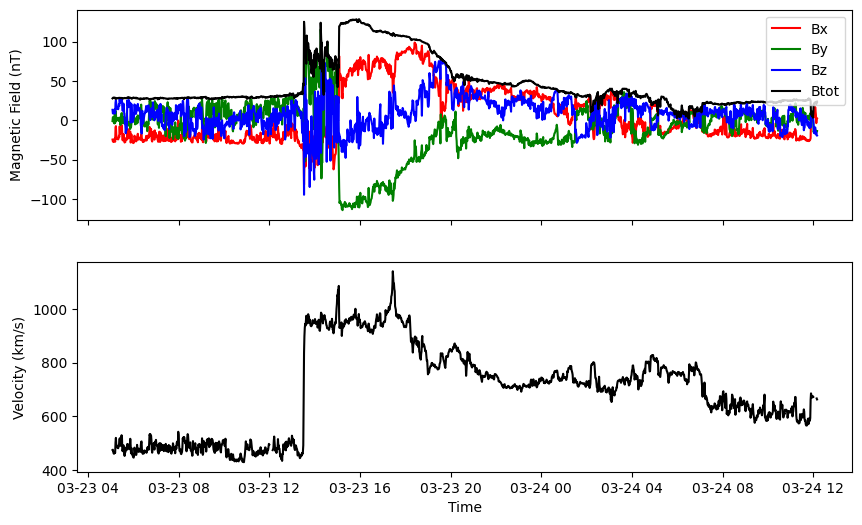

In [4]:
data_cache.quick_insitu_plot(reference_frame="HEEQ", delta_time_hours=10)

(<Figure size 1400x1000 with 1 Axes>, <PolarAxes: >)

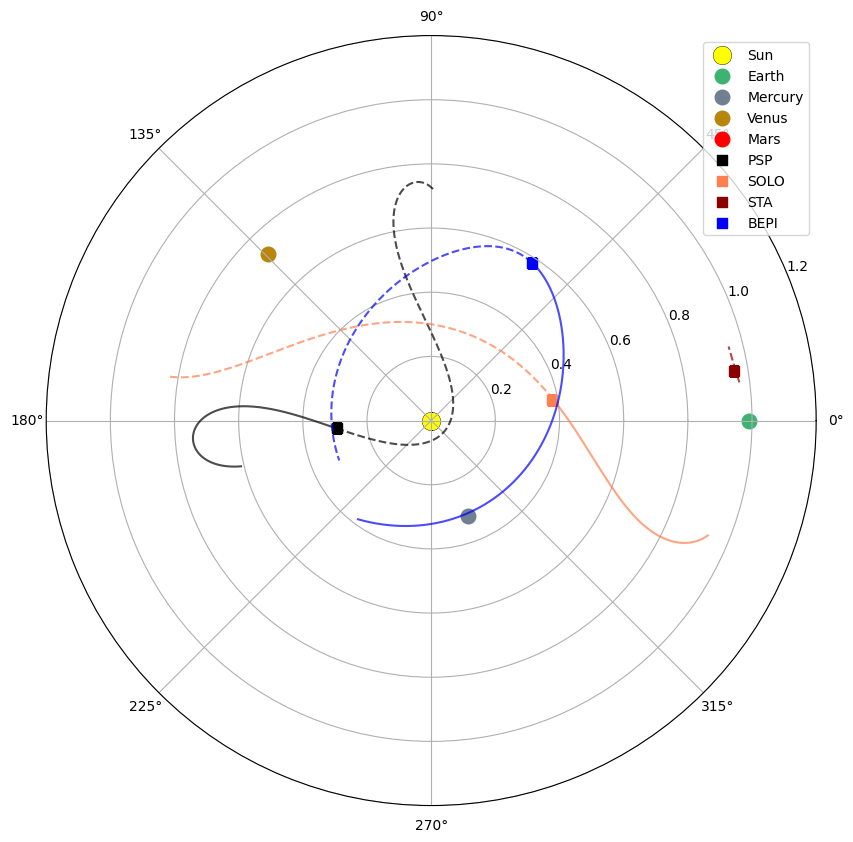

In [5]:
data_cache.quick_positions_plot()

(<Figure size 1000x600 with 2 Axes>,
 array([<Axes: ylabel='Magnetic Field (nT)'>,
        <Axes: xlabel='Time', ylabel='Velocity (km/s)'>], dtype=object))

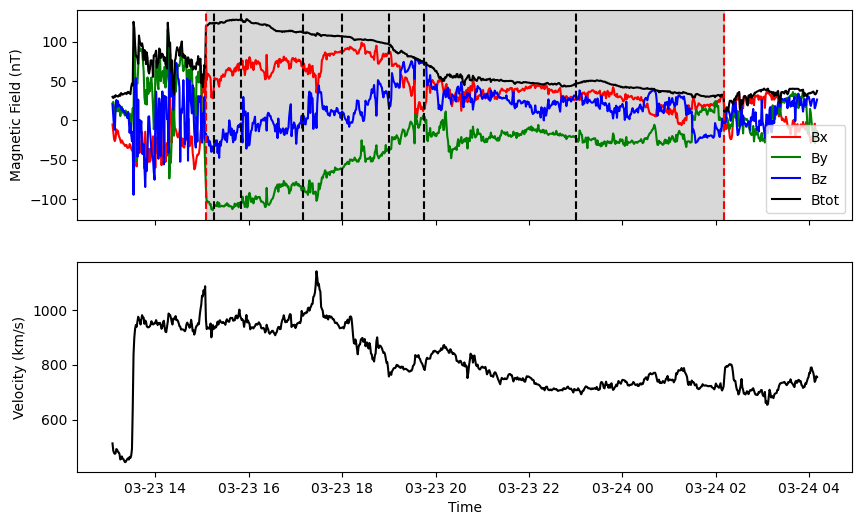

In [6]:
t_launch = cataloglaunchtime.replace(tzinfo=None) # choose launch time

t_s = None
t_e = None


t_fit =[
     datetime.datetime(2024, 3, 23, 15, 15, tzinfo=datetime.timezone.utc),
     datetime.datetime(2024, 3, 23, 15, 50, tzinfo=datetime.timezone.utc),
     datetime.datetime(2024, 3, 23, 17, 10, tzinfo=datetime.timezone.utc),
     datetime.datetime(2024, 3, 23, 18, 00, tzinfo=datetime.timezone.utc),
     datetime.datetime(2024, 3, 23, 19, 00, tzinfo=datetime.timezone.utc),
     datetime.datetime(2024, 3, 23, 19, 45, tzinfo=datetime.timezone.utc),
     datetime.datetime(2024, 3, 23, 23, 00, tzinfo=datetime.timezone.utc),
]

data_cache.check_fitting_points(t_s, t_e, t_fit)

In [7]:
longitude_delta = 40
latitude_delta = 30

speed_delta = 100

bg_v_delta = 100
bg_v = data_cache.v_mean_before_event


modelstatevar_ranges = [
    int(2**18) # ensemblesize
    ] + [
        [catalogevent['longitude'] - longitude_delta,catalogevent['longitude']+longitude_delta], # Longitude (HEEQ)
        [catalogevent['latitude'] - latitude_delta,catalogevent['latitude'] +latitude_delta], # Latitude (HEEQ)
        [0.,360.], # Inclination
        [0.05,0.35], # Diameter 1 AU 
        [1.,3.5], # Aspect Ratio  
        [21.5,21.5], # Launch Radius
        [catalogevent['speed'] - speed_delta, catalogevent['speed'] + speed_delta], # Launch Velocity
        [1.,2.0], # Expansion Rate
        [0.20,3.00], # Background Drag
        [bg_v - bg_v_delta, bg_v + bg_v_delta], # Background Velocity
        [-250.,250.], # T_Factor
        [1.,2.], # Magnetic Decay Rate
        [5.,65.], # Magnetic Field Strength 1 AU
    ]

modelkwargs = get_modelkwargs_ranges(modelstatevar_ranges)

multiprocessing = True

njobs = 4

itermin = 12
itermax = 15

n_particles = 512

In [8]:
rerun_fitting = False

output_path = Path.cwd().parent / "output"
output_folder = output_path / data_cache.idd

fit_number = "last" # "last" or integer

if rerun_fitting:
    extra_args = standard_fit(
        data_cache = data_cache,
        t_launch=t_launch,
        t_s=t_s,
        t_e=t_e,
        t_fit=t_fit,
        model_kwargs=modelkwargs,
        njobs=njobs,
        multiprocessing=multiprocessing,
        itermin=itermin,
        itermax=itermax,
        n_particles=n_particles,
    )

if fit_number == "last":
    fit_files = list(output_folder.glob("*.pickle"))
    fit_files.sort()
    fit_file = fit_files[-1]
else:
    fit_file = output_folder / "{0:02d}.pickle".format(fit_number)

with open(fit_file, "rb") as fh:
    extra_args = pickle.load(fh)

print("Loaded fit from file: ", fit_file)



Loaded fit from file:  /Users/hannahruedisser/3DCORE-ASWO/output/ICME_SOLO_MOESTL_20240323_01/11.pickle


In [9]:
ensemble_data = load_fit(output_folder=output_folder, fit_file=fit_file, data_cache=data_cache)

Ensemble path /Users/hannahruedisser/3DCORE-ASWO/output/ICME_SOLO_MOESTL_20240323_01/ensemble_11.pickle does not exist, calculating ensemble results...


  5%|▍         | 25/512 [01:29<28:59,  3.57s/it]


KeyboardInterrupt: 